In [ ]:
!pip install transformers datasets
!sudo apt-get install git-lfs
!pip install apache_beam mwparserfromhell
!pip install creolenltk
!pip install accelerate -U

In [ ]:
from huggingface_hub import notebook_login
from datasets import concatenate_datasets, load_dataset, Dataset
from google.colab import drive
from huggingface_hub import HfApi
import torch
import re
from bs4 import BeautifulSoup
from creolenltk.contraction_expansion import ContractionToExpansion
from tokenizers import ByteLevelBPETokenizer
import os
from transformers import RobertaConfig, RobertaTokenizer, RobertaForMaskedLM, LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import matplotlib.pyplot as plt

In [ ]:
notebook_login()

## 1. Prepare the dataset

### Load the datasets

In [ ]:
# Load different data
drive.mount('/content/gdrive/', force_remount=True)

with open("gdrive/MyDrive/2HaiRoBERT/data/data.txt", "r") as f:
    data = [re.sub(r'\s+([.,?!])', r'\1', line.rstrip('\n')) for line in f if len(line) > 1 and line.strip()]

Mounted at /content/gdrive/


In [ ]:
# Create a dataset
raw_datasets = Dataset.from_dict({"text": data})
raw_datasets

Dataset({
    features: ['text'],
    num_rows: 182313
})

### Preprocessing

In [ ]:
def preprocess_text(example):
    text = example['text']

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = re.sub(r'<.*?>', '', soup.get_text())

    # Remove non-alphabetic characters
    cleaned_text = re.sub(r'[^a-zA-Z\s,.!?]+', ' ', text)

    # Remove extra whitespaces
    cleaned_text = re.sub(' +', ' ', cleaned_text)

    # Expand contractions using CreoleNLTK
    expander = ContractionToExpansion()
    expanded_sentence = expander.expand_contractions(cleaned_text.strip())

     # Check if the sentence ends with '.', '?', or '!'
    if not re.search(r'[.!?]$', expanded_sentence):
        expanded_sentence += '.'

    example['text'] = expanded_sentence.capitalize()

    return example

In [ ]:
# Apply preprocessing to the raw_datasets
preprocessed_datasets = raw_datasets.map(preprocess_text)
preprocessed_datasets

Map:   0%|          | 0/182313 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 182313
})

In [ ]:
preprocessed_datasets['text'][:10]

['Bibliyot ki sou ent nou te.',
 'Nou kontan ou vin sou sit sa a.',
 'Se yon zouti ki p mwen te nou f rech ch nan div s lang nan piblikasyon temwen jewova yo.',
 'Pou ou kapab telechaje piblikasyon yo, ale sou lyen sa.',
 'Lendi mas.',
 'Jezi te konnen sa ki nan li mwen.',
 'Jezi te byen aji ak toule apot yo e li te montre li renmen yo.',
 'Ki leson nou aprann?',
 'Menmsi nou gen rezon pou nou fache akoz sa li te moun f , nou dwe f atansyon ak fason nou reyaji li yo f er .',
 'Li yon fr oswa yon s f yon bagay ki f nou fache, nou kapab mande te te nou poukisa sa li f a kontrarye mwen konsa?']

In [ ]:
# Define the file path for the output file
data_path = "gdrive/MyDrive/2HaiRoBERT/data/preprocessed_data.txt"

with open(data_path, "w") as output_file:
    for example in preprocessed_datasets:
        output_file.write(example['text'] + "\n")


## 2. Train a Tokenizer

In [ ]:
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()
paths = [data_path]

In [ ]:
# Customize training
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

In [ ]:
# Save files to drive
token_dir = 'gdrive/MyDrive/2HaiRoBERT/model'

if not os.path.exists(token_dir):
 os.makedirs(token_dir)

tokenizer.save_model(directory=token_dir)

['gdrive/MyDrive/2HaiRoBERT/model/vocab.json',
 'gdrive/MyDrive/2HaiRoBERT/model/merges.txt']

## 3. Preprocess the dataset

In [ ]:
#Define the configuration of the Model
config = RobertaConfig(
 vocab_size=52_000,
 max_position_embeddings=514,
 num_attention_heads=12,
 num_hidden_layers=12,
 type_vocab_size=1,
)

In [ ]:
# Load trained tokenizer
tokenizer = RobertaTokenizer.from_pretrained(token_dir, max_length=512)

In [ ]:
# Initialize the Model
model = RobertaForMaskedLM(config=config).cuda()

In [ ]:
# Build the Dataset
dataset = LineByLineTextDataset(
 tokenizer=tokenizer,
 file_path=data_path,
 block_size=128,
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
 tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

## 4. Pre-train the model

In [28]:
training_args = TrainingArguments(
 output_dir=token_dir,
 overwrite_output_dir=True,
 num_train_epochs=3,
 per_device_train_batch_size=64,
 save_steps=10_000,
 save_total_limit=2,
)

trainer = Trainer(
 model=model,
 args=training_args,
 data_collator=data_collator,
 train_dataset=dataset,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,5.606000
1000,4.576800
1500,4.175900
2000,3.859200
2500,3.584300
3000,3.398300
3500,3.274300
4000,3.145800
4500,3.066700
5000,2.986500


Step,Training Loss
500,5.606000
1000,4.576800
1500,4.175900
2000,3.859200
2500,3.584300
3000,3.398300
3500,3.274300
4000,3.145800
4500,3.066700
5000,2.986500


TrainOutput(global_step=8547, training_loss=3.3590352272755837, metrics={'train_runtime': 2881.3798, 'train_samples_per_second': 189.818, 'train_steps_per_second': 2.966, 'total_flos': 2.0950823368131456e+16, 'train_loss': 3.3590352272755837, 'epoch': 3.0})

In [29]:
# Save the Model
trainer.save_model(token_dir)

## Test The Model

In [30]:
from transformers import pipeline
fill_mask = pipeline(
 'fill-mask',
 model=token_dir,
 tokenizer=token_dir
)
fill_mask('Bonjou koman ou <mask>?')

[{'score': 0.055453166365623474,
  'token': 277,
  'token_str': ' a',
  'sequence': 'Bonjou koman ou a?'},
 {'score': 0.03738952428102493,
  'token': 320,
  'token_str': ' ou',
  'sequence': 'Bonjou koman ou ou?'},
 {'score': 0.03688506782054901,
  'token': 293,
  'token_str': ' an',
  'sequence': 'Bonjou koman ou an?'},
 {'score': 0.029906965792179108,
  'token': 272,
  'token_str': ' yo',
  'sequence': 'Bonjou koman ou yo?'},
 {'score': 0.028476135805249214,
  'token': 292,
  'token_str': ' sa',
  'sequence': 'Bonjou koman ou sa?'}]

In [31]:
fill_mask('Li <mask> anle a.')

[{'score': 0.0833139568567276,
  'token': 274,
  'token_str': ' te',
  'sequence': 'Li te anle a.'},
 {'score': 0.052262987941503525,
  'token': 284,
  'token_str': ' nou',
  'sequence': 'Li nou anle a.'},
 {'score': 0.022173967212438583,
  'token': 535,
  'token_str': ' fini',
  'sequence': 'Li fini anle a.'},
 {'score': 0.012826181948184967,
  'token': 278,
  'token_str': ' li',
  'sequence': 'Li li anle a.'},
 {'score': 0.012308260425925255,
  'token': 310,
  'token_str': ' mwen',
  'sequence': 'Li mwen anle a.'}]

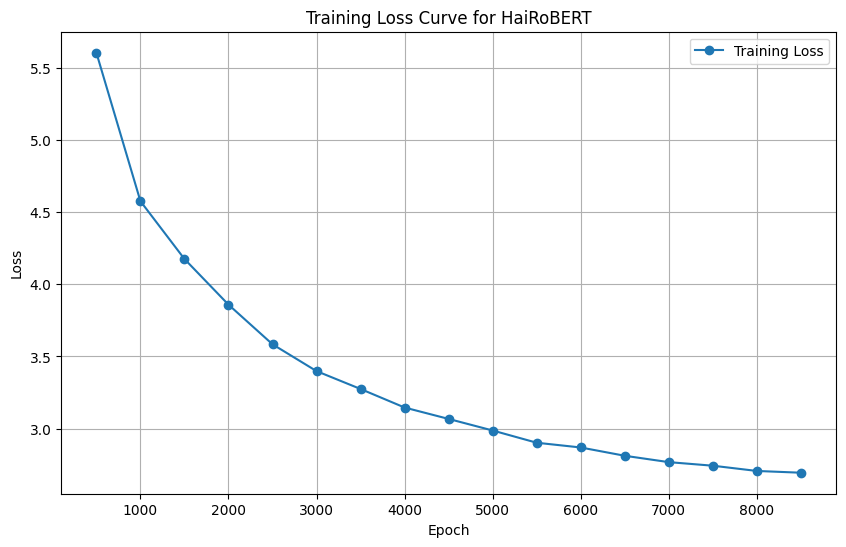

In [32]:
# Plot the training loss
loss_results = trainer.state.log_history
losses = [result["loss"] for result in loss_results[:-1]]
steps = [result["step"] for result in loss_results[:-1]]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for HaiRoBERT')
plt.grid(True)
plt.legend()
plt.show()